# Estimating Borrower Credit Worthiness

This is an [old Kaggle competition](kaggle.com/c/GiveMeSomeCredit) that expired 6 years ago that still garners quite a bit of interest - perhaps due to the dataset being fairly interesting and it being one of the few widely followed credit estimation problems. This is my hack at the same.

Since this was meant to be a learning experience, I refrained as much as possible from the competition's discussion boards, getting further ideas (mentioned at the end of this notebook). A lot of work went into this project (**40 odd Kaggle submissions**) before the final cut seen here; non-trivial tasks are listed below, ordered by occurence:

1. Feature visualizations, modifications (like log) to deal with highly right-skewed features (*didn't work*)
2. Naive Bayes classification (*dismal results*)
3. Random Forest trials with hyper-parameter optimizations (*large improvement in AUC*)
4. Feature engineering trial and error for 2 new features, using Random Forests
5. Further feature engineering (incuding some insane ones, with a train of thought akin to opium-fuelled Romantic-era poets)
6. Model evaluation metrics tried - logloss, Kappa, Accuracy, AUC (finally settling on AUC, since that is the metric being used by competition judgers)
7. Switch to boosted trees from Random Forests for training

The final model output led to an *Implied Rank of 7 out of 924 participants* (sorted by AUC) in Kaggle's private leaderboard. Not too bad for a week's work (and a much simpler model than the winning entries)

In [1]:
set.seed(105)

# Setting working directory, loading packages and data
setwd("C:/Users/Pratik/Desktop/Learning/Kaggle/SirThodaCreditPlz/")
suppressWarnings(suppressMessages(library(randomForest)))
suppressWarnings(suppressMessages(library(xgboost)))
suppressWarnings(suppressMessages(library(pROC)))
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(plyr)))
suppressWarnings(suppressMessages(library(dplyr)))

data <- read.csv("train.csv")
round(colSums(is.na(data)) / nrow(data), 3)

SeriousDlqin2yrs RevolvingUtilizationOfUnsecuredLines 
                               0.000                                0.000 
                                 age NumberOfTime30.59DaysPastDueNotWorse 
                               0.000                                0.000 
                           DebtRatio                        MonthlyIncome 
                               0.000                                0.198 
     NumberOfOpenCreditLinesAndLoans              NumberOfTimes90DaysLate 
                               0.000                                0.000 
        NumberRealEstateLoansOrLines NumberOfTime60.89DaysPastDueNotWorse 
                               0.000                                0.000 
                  NumberOfDependents 
                               0.026

There are some issues with regards to missing values for incomes and dependents. (~20% and ~2.6% of total rows, respectively)

In [2]:
rows_missing_income <- is.na(data$MonthlyIncome)
tail(data[rows_missing_income,])

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents
149976,0,0.022088398,58,0,2716,NA,8,0,2,0,0
149977,0,0.000627439,76,0,60,NA,5,0,0,0,0
149978,0,0.236449864,29,0,349,NA,3,0,0,0,0
149985,0,0.037548123,84,0,25,NA,5,0,0,0,0
149993,0,0.871975945,50,0,4132,NA,11,0,1,0,3
149998,0,0.246043918,58,0,3870,NA,18,0,1,0,0


An interesting trend seems to be that **for missing monthly incomes, debt ratios are large integers**, whereas for other cases, the ratios are look more like the percentages they should really be! Further analysis (in excel) confirms this pattern, and a hypothesis is constructed - *maybe, just MAYBE, someone has incorrectly entered the monthly incomes in the debt ratio column for 20% of total cases.* This would require feature correction as follows.

In [3]:
data$MonthlyIncome[rows_missing_income] <- data$DebtRatio[rows_missing_income]

Ceteris paribus, model performance was vastly better, after above feature modificatioDebt ratio for these cases is then estimated (for a lack of alternatives) as inverse of corrected income. Now, as for the dependents' missing value, thhe approach taken is to assign them no dependents (not as significant as income, since only 2.6% cases affected by this probem)

In [4]:
data$DebtRatio[rows_missing_income] <- 1 / data$DebtRatio[rows_missing_income]
data$NumberOfDependents[is.na(data$NumberOfDependents)] <- 0
round(colSums(is.na(data)) / nrow(data), 3)   # Problem solved

SeriousDlqin2yrs RevolvingUtilizationOfUnsecuredLines 
                                   0                                    0 
                                 age NumberOfTime30.59DaysPastDueNotWorse 
                                   0                                    0 
                           DebtRatio                        MonthlyIncome 
                                   0                                    0 
     NumberOfOpenCreditLinesAndLoans              NumberOfTimes90DaysLate 
                                   0                                    0 
        NumberRealEstateLoansOrLines NumberOfTime60.89DaysPastDueNotWorse 
                                   0                                    0 
                  NumberOfDependents 
                                   0

#### Moving on to training! 

A RandomForests run using above features was still not good enough, with max AUC scores of 0.81 v/s 0.8695 winning score. Two improvements that seemed like the next logical steps:
* Using boosted trees (xgboost) over RFs (due to past experience in imbalanced class classification improvement by boosting)
* Further parameter engineering

Elaborating further on the second step, the ideas that popped up and were implemented are given below:
1. Were I a betting man, I would say that monthly income per dependent seems important
2. Low income, with high number of real estate loans or open credit lines could be construed as signs of a retail credit bubble
3. A hybrid (weighted) delinquency measure for overdue days
4. Old people likely to have pensions, social security that *might* not show up in monthly income
5. Setting RevolvingUtilizationOfUnsecuredLines more than 1 (highly right-skewed feature), equal to 1
6. [29/41 Rule for mortgage DTI](budgeting.thenest.com/calculate-29-41-qualifying-ratio-mortgage-loan-28249.html)
7. Making rule for suspicious looking (large round numbers) RevolvingUtilizationOfUnsecuredLines
8. [First digit of income](https://en.wikipedia.org/wiki/Benford%27s_law)
9. Round number annual incomes, since probably a salaried individual!

Above thoughts (in code form) are given below:

In [5]:
# 1
data$IncomePerCapita <- data$MonthlyIncome / (1 + data$NumberOfDependents)

# 2
data$IncomePerLoanOrLine <- data$MonthlyIncome / (1 + data$NumberRealEstateLoansOrLines + 
                                                    data$NumberOfOpenCreditLinesAndLoans)

# 3
data$HybridDelinquent <- data$NumberOfTimes90DaysLate^2 +
  data$NumberOfTime60.89DaysPastDueNotWorse^1.5 +
  data$NumberOfTime30.59DaysPastDueNotWorse

# 4
data$old_age <- 1 * (data$age >= 60)

# 5
data$new_RevolvingUtilizationOfUnsecuredLines <- pmin(1, data$RevolvingUtilizationOfUnsecuredLines)

# 6
data$rule29 <- 1 * (data$DebtRatio >= 0.29 & data$DebtRatio < 0.41)
data$rule41 <- 1 * (data$DebtRatio >= 0.41)

# 7
data$round_RevolvingUtilizationOfUnsecuredLines <- 1 * (data$RevolvingUtilizationOfUnsecuredLines > 0 & 
                                                          round(data$RevolvingUtilizationOfUnsecuredLines,0) == data$RevolvingUtilizationOfUnsecuredLines)

# 8
data$FirstDigitIncome <- as.numeric(substr(data$MonthlyIncome, 1, 1))

# 9
data$ProbablySalaried <- 1 * ((data$MonthlyIncome * 12) - floor(data$MonthlyIncome * 12 / 1000) * 1000 == 0)

ncol(data %>% select(-c(SeriousDlqin2yrs)))

[1] 20

Thus, there are 20 features overall, from 10 originally. Now that the feature engineering part of the two-pronged plan is out of the way, let's focus on getting [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) up and running. This is one of the few models which has consistently worked on class imbalance problems that I have faced, and hence, I brought this one up (no other fancy reason, if I am being candid).

For exact steps required to set-up the problem, please refer the link above. The steps (in code) have been given below 

In [6]:
# Defining training matrices
total_X <- as.matrix(data %>% select(-c(SeriousDlqin2yrs)))
total_Y <- data$SeriousDlqin2yrs
total_matrix <- xgb.DMatrix(data=total_X,label=total_Y)

# Setting-up hyperparameter optimization grid
# Note that the actual hyper-parameter grid used was much larger than the one below; 
# but for illustration purposes, this shall do.
xgb_grid_1 = expand.grid(
  nrounds = c(200,400),
  eta = 0.05,
  max_depth = c(4,6,8),
  gamma = c(0.5,1),
  min_child_weight = c(1,5),
  colsample_bytree = 0.3,
  subsample = 1
)

# Packing training control parameters; Using a 5-fold CV approach
xgb_trcontrol_1 = trainControl(
  method = "cv",
  number = 5,
  verboseIter = F,
  returnData = F,
  returnResamp = "all",                       
  classProbs = T,
  summaryFunction = multiClassSummary,
  allowParallel = T
)

y_1 <- as.factor(total_Y)
levels(y_1) <- LETTERS[1:length(unique(y_1))]

# Training Loop over hyper-parameter grid
xgb_train_1 = train(
  x = total_X,
  y = as.factor(y_1),
  trControl = xgb_trcontrol_1,
  tuneGrid = xgb_grid_1,
  metric = "AUC",
  method = "xgbTree"
)

# Best output as per above optimization
params <- xgb_train_1$bestTune
print(paste("Best AUC from model is", max(xgb_train_1$results$AUC)))

+ Fold1: eta=0.05, max_depth=4, gamma=0.5, colsample_bytree=0.3, min_child_weight=1, subsample=1, nrounds=400 
- Fold1: eta=0.05, max_depth=4, gamma=0.5, colsample_bytree=0.3, min_child_weight=1, subsample=1, nrounds=400 
+ Fold1: eta=0.05, max_depth=4, gamma=0.5, colsample_bytree=0.3, min_child_weight=5, subsample=1, nrounds=400 
- Fold1: eta=0.05, max_depth=4, gamma=0.5, colsample_bytree=0.3, min_child_weight=5, subsample=1, nrounds=400 
+ Fold1: eta=0.05, max_depth=4, gamma=1.0, colsample_bytree=0.3, min_child_weight=1, subsample=1, nrounds=400 
- Fold1: eta=0.05, max_depth=4, gamma=1.0, colsample_bytree=0.3, min_child_weight=1, subsample=1, nrounds=400 
+ Fold1: eta=0.05, max_depth=4, gamma=1.0, colsample_bytree=0.3, min_child_weight=5, subsample=1, nrounds=400 
- Fold1: eta=0.05, max_depth=4, gamma=1.0, colsample_bytree=0.3, min_child_weight=5, subsample=1, nrounds=400 
+ Fold1: eta=0.05, max_depth=6, gamma=0.5, colsample_bytree=0.3, min_child_weight=1, subsample=1, nrounds=400 
-

Selecting tuning parameters
Fitting nrounds = 200, max_depth = 6, eta = 0.05, gamma = 0.5, colsample_bytree = 0.3, min_child_weight = 1, subsample = 1 on full training set
[1] "Best AUC from model is 0.866588567296256"


The parameter set gave ~0.8691 AUC on Kaggle's private board evaluation **(Implied Rank - 7)** It is possible that the result can get better with a larger hyper-parameter grid, but I decided to spare my laptop the pain. Of course, I have a benefit from hindsight and the fact that I can actually see the private leaderboard.

* __nrounds__ (Number of trees) = 200
* __max_depth__ (Max depth of each tree) = 6
* __eta__ (keeping weak learners weak) = 0.05
* __gamma__ (minimum gain required to split node)= 0.5
* __colsample_bytree__ (column subsampling for creation of each tree) = 0.3
* __min_child_weight__ (min weight in each leaf node) = 5
* __subsample__ (row subsampling to create trees) = 1

For further details on parameter descriptions, I would redirect you XGBoost's [insightful webpage](http://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)

Next step is to fit the model using the parameters obtained above.

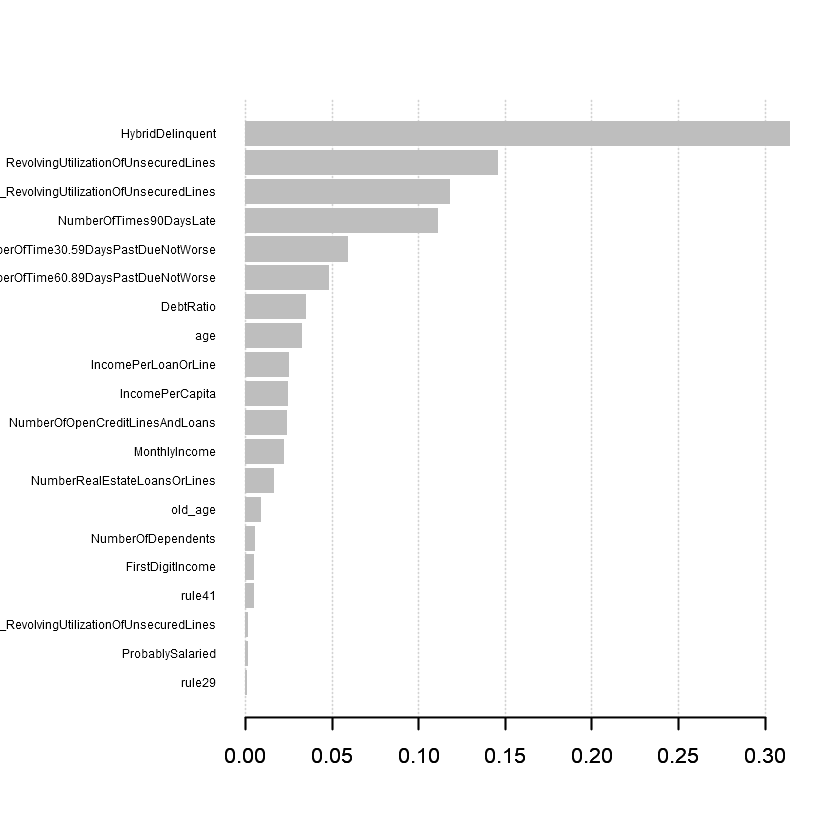

In [7]:
xgb_params <- c(list(objective = "multi:softprob",eval_metric = "auc",
                     num_class = 2),as.list(params %>% select(-nrounds)))
fit <- xgb.train(params=xgb_params,data=total_matrix,nrounds=params$nrounds)

VarImp_matrix <- xgb.importance(feature_names = dimnames(total_matrix)[[2]], model = fit)
xgb.plot.importance(VarImp_matrix, measure = 'Gain')

The above chart is known as a 'variable importance plot'. As the name suggests, it shows the importance or 'information gain' that can be attributed to an individual feature. It is important in case we want to trim the fat (eliminate variables that don't contribute as much) or just want to get an understanding of what is really driving variance in the dependent variable.

It is clear that *Hybrid Delinquency, Revloving Credit Line Utilization and Debt Ratio* are the most important features. Most engineered features (unfortunately) do not bring much to the table!

In [8]:
test <- read.csv("test.csv")

test_rows_missing_income <- is.na(test$MonthlyIncome)
test$MonthlyIncome[test_rows_missing_income] <- test$DebtRatio[test_rows_missing_income]
test$DebtRatio[test_rows_missing_income] <- 1 / test$DebtRatio[test_rows_missing_income]
# test$NumberOfDependents[is.na(test$NumberOfDependents)] <- median_dependents
test$NumberOfDependents[is.na(test$NumberOfDependents)] <- 0

test$IncomePerCapita <- test$MonthlyIncome / (1 + test$NumberOfDependents)
test$IncomePerLoanOrLine <- test$MonthlyIncome / (1 + test$NumberRealEstateLoansOrLines + 
                                                    test$NumberOfOpenCreditLinesAndLoans)
test$HybridDelinquent <- test$NumberOfTimes90DaysLate^2 +
  test$NumberOfTime60.89DaysPastDueNotWorse^1.5 +
  test$NumberOfTime30.59DaysPastDueNotWorse
test$old_age <- 1 * (test$age >= 60)
test$new_RevolvingUtilizationOfUnsecuredLines <- pmin(1, test$RevolvingUtilizationOfUnsecuredLines)
test$rule29 <- 1 * (test$DebtRatio >= 0.29 & test$DebtRatio < 0.41)
test$rule41 <- 1 * (test$DebtRatio >= 0.41)
test$round_RevolvingUtilizationOfUnsecuredLines <- 1 * (test$RevolvingUtilizationOfUnsecuredLines > 0 & 
                                                          round(test$RevolvingUtilizationOfUnsecuredLines,0) == test$RevolvingUtilizationOfUnsecuredLines)
test$FirstDigitIncome <- as.numeric(substr(test$MonthlyIncome, 1, 1))
test$ProbablySalaried <- 1 * ((test$MonthlyIncome * 12) - floor(test$MonthlyIncome * 12 / 1000) * 1000 == 0)

test_matrix <- as.matrix(test[,-1])
test_pred_boost <- predict(fit, test_matrix)
test_pred_boost <- matrix(test_pred_boost, nrow=2, ncol=length(test_pred_boost)/2) %>% t() %>% data.frame()
test_pred_boost <- test_pred_boost[2]
names(test_pred_boost) <- "Probability"
head(test_pred_boost)

# write.csv(test_pred_boost,file="sampleEntry.csv")

Probability
0.06057938
0.04931655
0.02132925
0.07474942
0.09511093
0.02907733


The project was an interesting use-case for boosted trees, since there were very few features (originally, and even post-engineering) and much more instances than features. I think that results could be improved further with larger hyper-parameter grids. Also, my score is over-estimated, since actual competitors wouldn't have the benefit of access to the private leaderboard rankings in real-time! 

**EDIT**: As it turns out, [some guy](kaggle.com/c/GiveMeSomeCredit/discussion/31514) beat the damn leaderboard armed with just an xgboost (and a GPU!) Goes to show the efficacy of boosting.